![](https://www.domsoria.com/wp-content/uploads/2019/11/keras.png)

# Convolutional Neural Networks

One of the most exciting areas of deep learning is for sure _computer vision_. This is based on __Convolutional Neural Networks__.


#### Big Data problem
Computer vision is a big data problem. Indeed, dealing with images makes the number of features exploding.

For instance, consider a $1000 \times 1000$ pixels colourful image. 
The number of features is then
$$1000 \times 1000 \times 3 \sim 10^6$$
And for a $1000$ hidden units layer, the number of weights for the first layer is $\sim 10^9$. 
Hence, just for the first layer we have a billion of weights to train.

### CNN layers ###

#### Convolutional neural networks ####
These are the best tool for image related task, basic ingredient for computer vision and actually by far the largest success of Deep Learning.
However, they are quite complex objects and data demanding, indeed, people talk about _data hungry_.

**What is the convolution?**

![title](images/conv.png)

> Convolution is a mathematical operation on two functions (f and g) to produce a third function that expresses how the shape of one is modified by the other.

![title](images/fgge.png)

**Convolutional pass on an image**

A matrix transformation on each element

![title](images/convExample.png)

Grey blocks values in the image below can be calculated by several operations, sum, average, max etc.

![](https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

Here an explicit example

![](https://media2.giphy.com/media/i4NjAwytgIRDW/200.gif)

**max pooling (or average pooling)**

![title](images/mpool.png)

every portion of the matrix is averages (or max) by elements: helps transforming an image with large size to an image of smaller size
    
    1024 --> 512 --> 256 pixels

## Edge Detection

Consider a gray scale image (for simplicity), thus for example $X = 1000 \times 1000 \times 1$.

Concretely let's take a very simple image

![](images/VerticalEdge.jpg)



**Question**

> Find the matrix form of such image, knowing a black pixel has value 0, and a white one has value 100.

**Answer**

$$\begin{pmatrix} 100 & \ldots & 100 & 0 & \ldots & 0 \\
\vdots  &  \ddots &  \vdots & \vdots  & \ddots &  \vdots \\
100 & \ldots & 100 & 0 & \ldots & 0 \\
\end{pmatrix}$$


Now, a simple exercise to show how by a simple convolutional __filter__ (or __kernel__) one can implement an edge detector.

The __edge detector kernel__ is made by the following $3 \times 3$ matrix

$$\begin{pmatrix} 1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1 \\
\end{pmatrix}$$


![](https://miro.medium.com/max/1920/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

**Excercise**

Compute the convolution 

$$\begin{pmatrix} 100 & 100 & 100 & 100 & 0 & 0 & 0 & 0  \\
100 & 100 & 100 & 100 & 0 & 0 & 0 & 0 \\
100 & 100 & 100 & 100 & 0 & 0 & 0 & 0 \\
100 & 100 & 100 & 100 & 0 & 0 & 0 & 0 \\
\end{pmatrix} \star \begin{pmatrix} 1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1 \\
\end{pmatrix}$$

**Answer**

$$\begin{pmatrix} 100 & 100 & 100 & 0 & 0 & 0  \\
100 & 100 & 100 & 0 & 0 & 0 \\
100 & 100 & 100 & 0 & 0 & 0 \\
100 & 100 & 100 & 0 & 0 & 0 \\
100 & 100 & 100 & 0 & 0 & 0 \\
100 & 100 & 100 & 0 & 0 & 0 \\
\end{pmatrix} \star \begin{pmatrix} 1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1 \\
\end{pmatrix} = \begin{pmatrix} 0 & 300 & 300 & 0  \\
0 & 300 & 300 & 0  \\
0 & 300 & 300 & 0  \\
0 & 300 & 300 & 0  \\
\end{pmatrix} $$

# Convolutional Neural Network

We will build a Convolutional deep network, and study how this can be useful to work with images and computer vision tasks.

**After this lecture you will be able to:**
- Build and apply a deep convolutional neural network to supervised learning.

Let's get started!

In [1]:
# Import libraries
import time
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from utils.dnn_app_utils_v3 import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from utils.resnets_utils import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
import scipy.misc
from matplotlib.pyplot import imshow

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

import skimage.transform
import imageio

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# Convolution

### SIGNS Dataset

One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.
<img src="images/hands.png" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: SIGNS dataset <br> <font color='black'> </center>

The following cell loads the dataset.

In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [3]:
n_classes = len(classes)

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


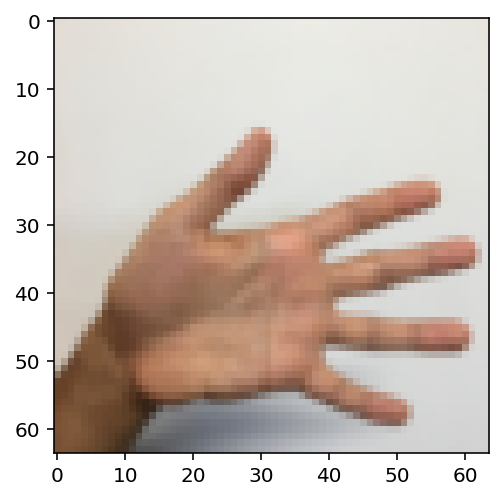

In [4]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As you can see we have a set of hand signs indicating numbers.

#### Some preprocessing

In [5]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


**Note** that 12288 comes from $64 \times 64 \times 3$. Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

**Our goal** is to build an algorithm capable of recognizing a sign with high accuracy. To do so, you are going to build a Keras model that is almost the same as one you have previously built for cat recognition (but now using a softmax output). It is a great occasion to think about how we structure Deep network projects. 

**The model** is a convolutional model *CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

## The model

In [6]:
# model building
input_shape = X_train.shape[1:] # number of features
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     padding = "same", 
                     input_shape=input_shape))
model.add(MaxPool2D(pool_size=(8, 8), strides = (8,8), padding="same"))
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     padding = "same", 
                     input_shape=input_shape))
model.add(MaxPool2D(pool_size=(4, 4), strides = (4, 4), padding="same"))
model.add(Flatten())
model.add(Dense(n_classes, activation='sigmoid'))

opt = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 10,918
Trainable params: 10,918
Non-trainable params: 0
____________________________________________________

In [7]:
# fit model
history = model.fit(X_train, Y_train, batch_size=16, epochs=20, validation_split=0.2, shuffle=True)

Epoch 1/20
54/54 [==============================] - 2s 30ms/step - loss: 0.5640 - accuracy: 0.1928 - val_loss: 0.4476 - val_accuracy: 0.1806
Epoch 2/20
54/54 [==============================] - 1s 14ms/step - loss: 0.4492 - accuracy: 0.2162 - val_loss: 0.4479 - val_accuracy: 0.3056
Epoch 3/20
54/54 [==============================] - 1s 13ms/step - loss: 0.4406 - accuracy: 0.2616 - val_loss: 0.4351 - val_accuracy: 0.2870
Epoch 4/20
54/54 [==============================] - 1s 13ms/step - loss: 0.4348 - accuracy: 0.2966 - val_loss: 0.4253 - val_accuracy: 0.4120
Epoch 5/20
54/54 [==============================] - 1s 13ms/step - loss: 0.4186 - accuracy: 0.4218 - val_loss: 0.4061 - val_accuracy: 0.4167
Epoch 6/20
54/54 [==============================] - 1s 14ms/step - loss: 0.3944 - accuracy: 0.4907 - val_loss: 0.3843 - val_accuracy: 0.4352
Epoch 7/20
54/54 [==============================] - 1s 17ms/step - loss: 0.3625 - accuracy: 0.5615 - val_loss: 0.3499 - val_accuracy: 0.6111
Epoch 8/20
54

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


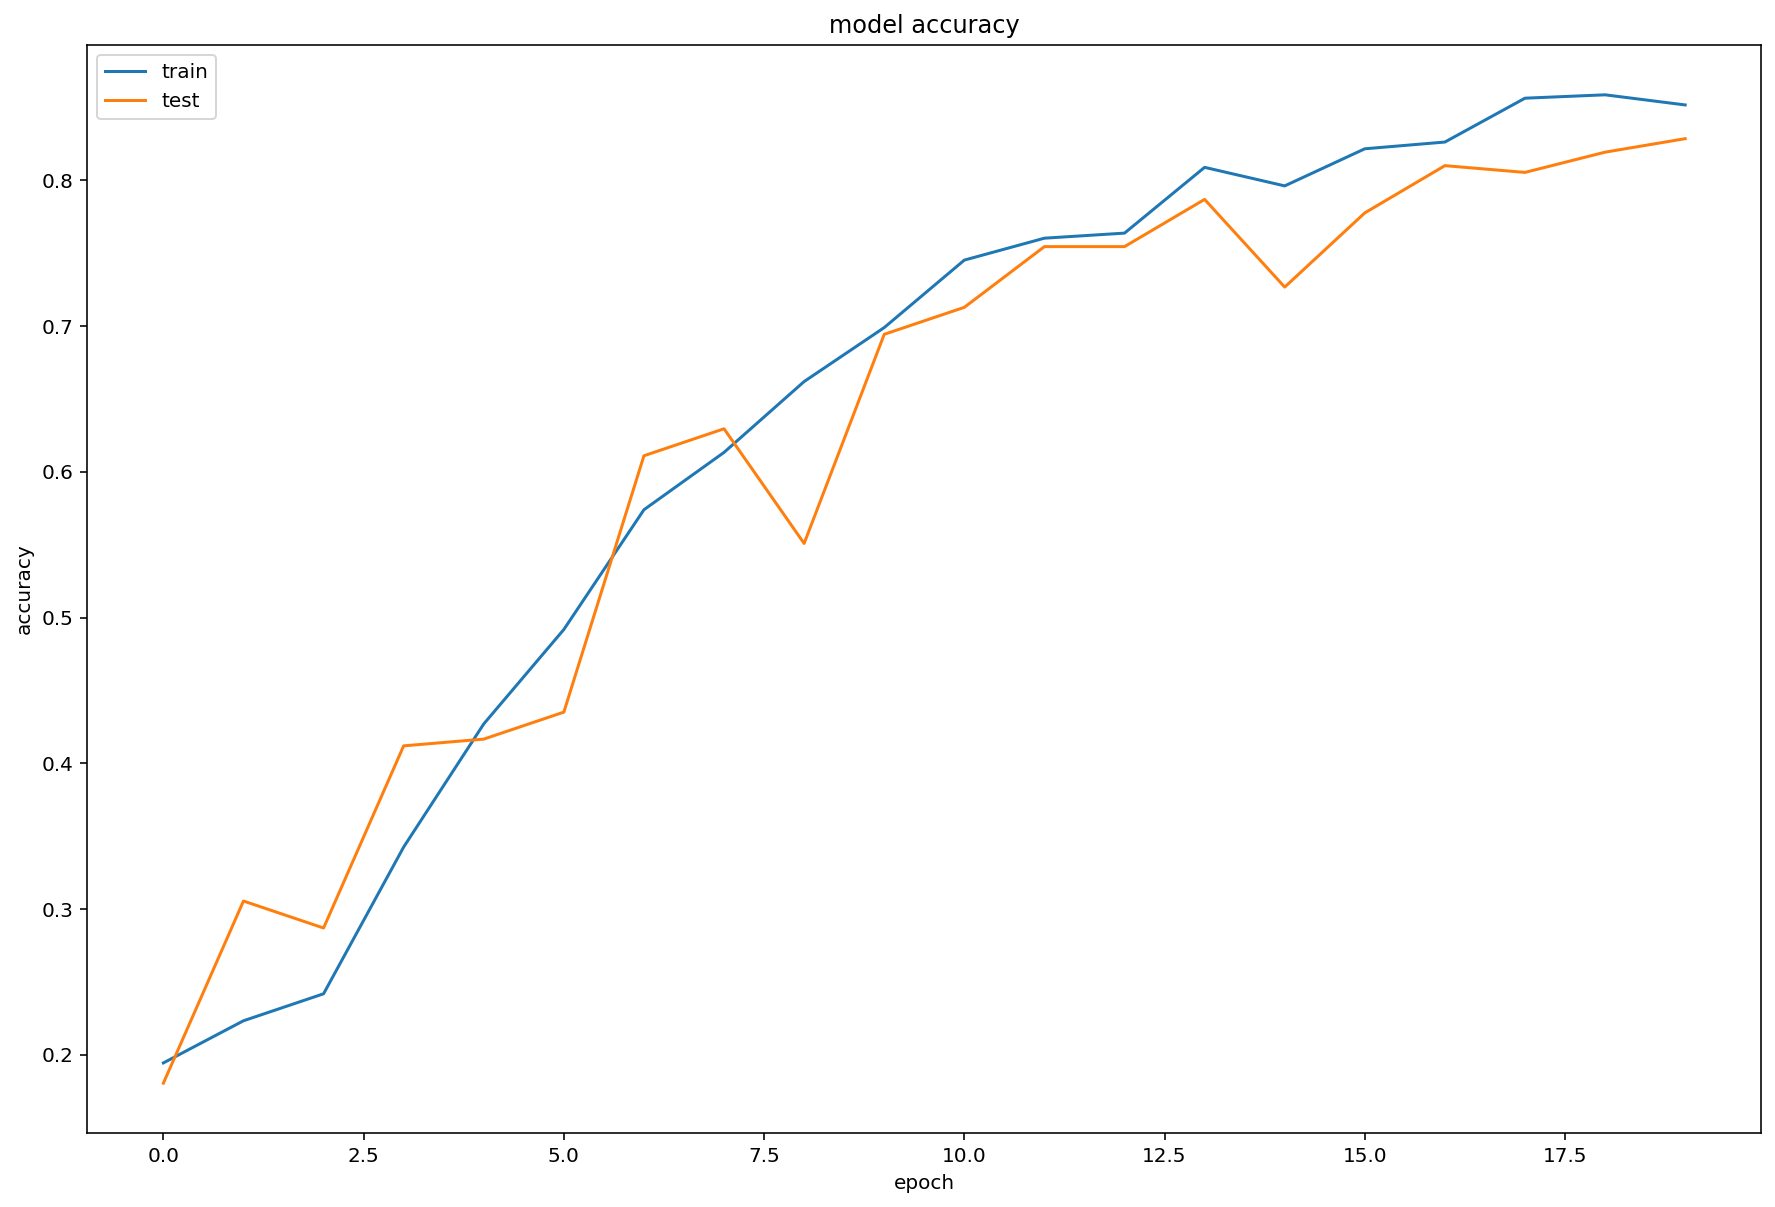

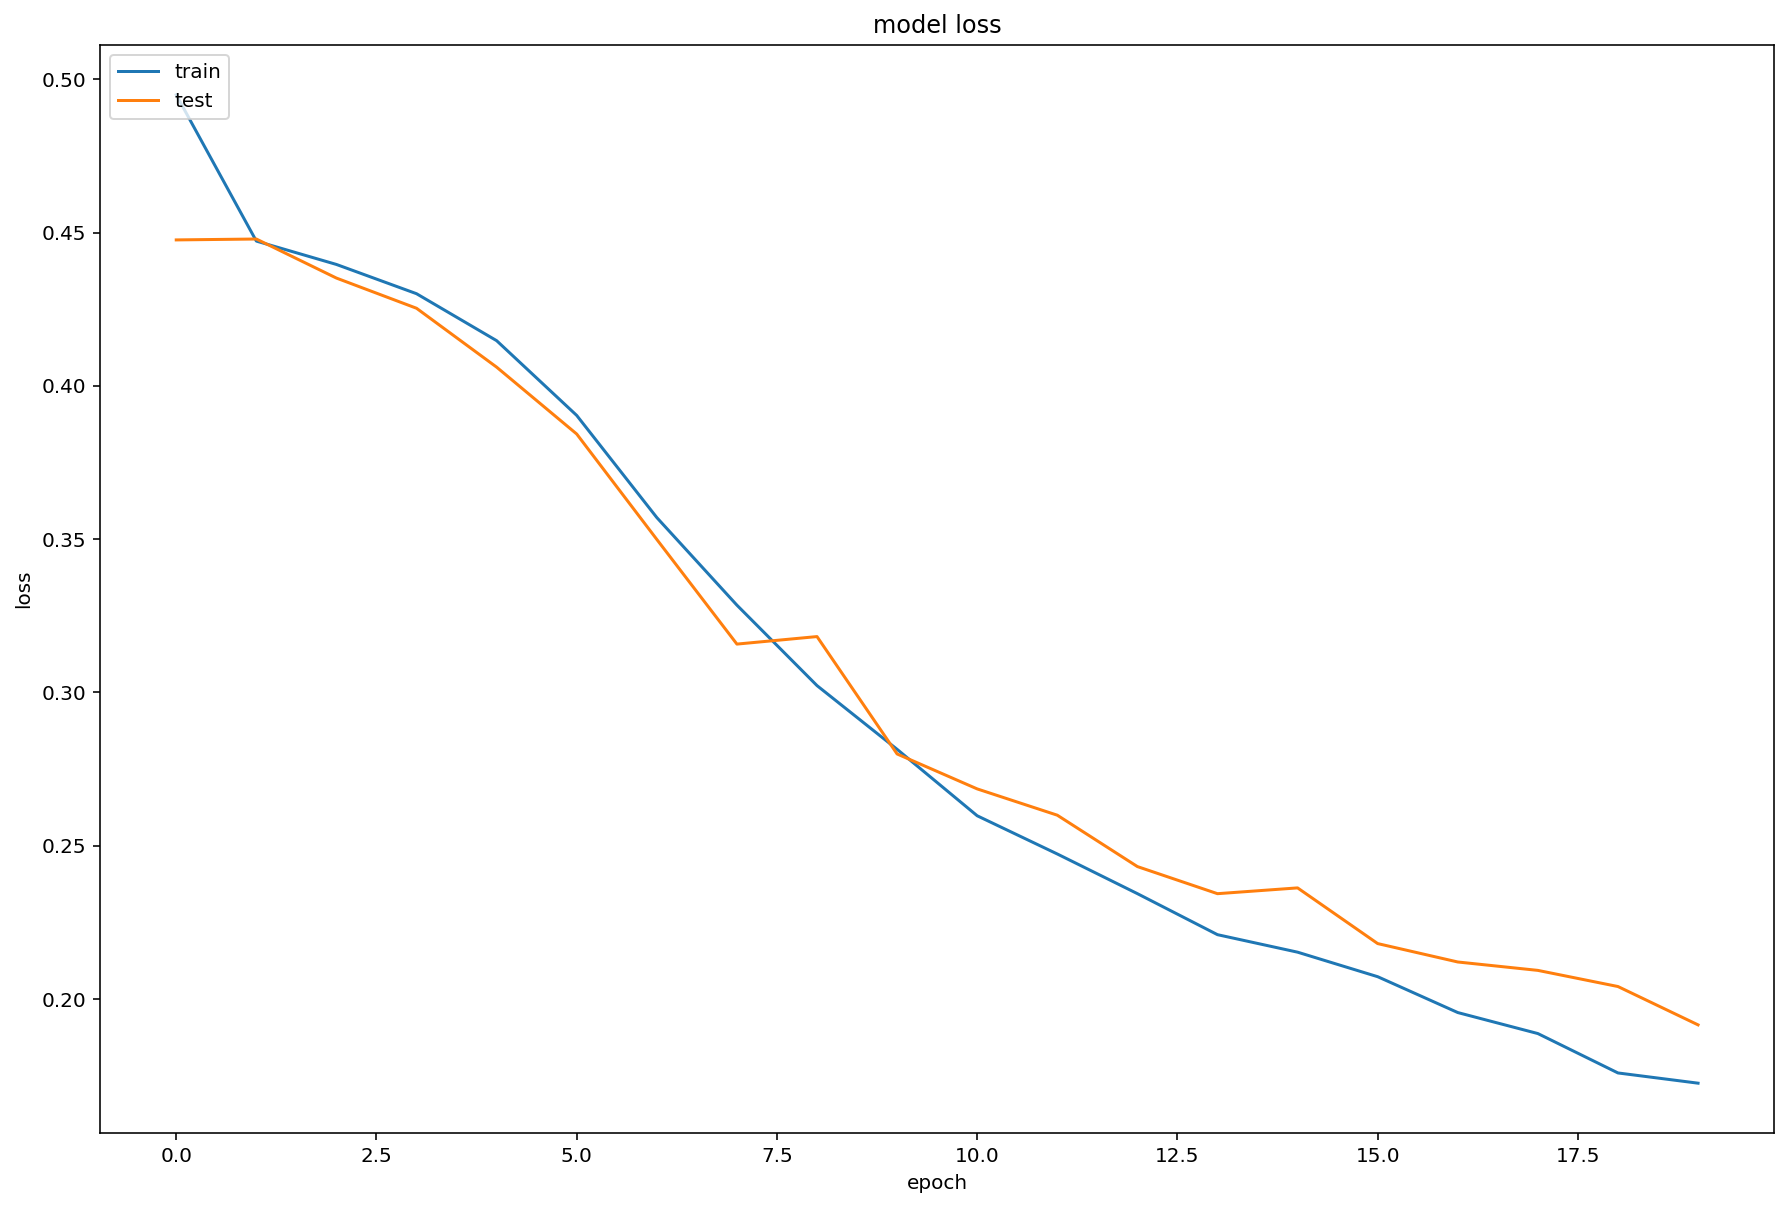

In [8]:
print(history.history.keys())

plt.figure(figsize=(15,10))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(15,10))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
train_metr = model.evaluate(X_train, Y_train, verbose=0)
results = model.evaluate(X_test, Y_test, verbose=0)

print(f'Training {model.metrics_names[0]}: {train_metr[0]} \nTraining {model.metrics_names[1]}: {train_metr[1]}' )
print('='*35)
print(f'Test {model.metrics_names[0]}: {results[0]} \nTest {model.metrics_names[1]}: {results[1]}' )

Training loss: 0.165050208568573 
Training accuracy: 0.8796296119689941
Test loss: 0.18734747171401978 
Test accuracy: 0.8833333253860474


We can see that the model has an accuracy of $88$%, not bad. Much nicer than a dense "plain" network.

## A further example: MNIST 

A very popular dataset (and problem) is the one of hand-written digits.

We can see how a Deep Learning approach performs much better than a random forest classifier for example

In [10]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.layers import MaxPooling2D

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

So we define a CNN model and a Random forest model to compare results

In [11]:
def CNNModel(num_classes):
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, num_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# input image dimensions
image_height, image_width, num_channels = 28, 28, 1
img_rows, img_cols = 28, 28

num_classes = 10

# the data, split between train and test sets
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train_orig.reshape(x_train_orig.shape[0], 1, img_rows, img_cols)
    x_test = x_test_orig.reshape(x_test_orig.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train_orig.reshape(x_train_orig.shape[0], img_rows, img_cols, 1)
    x_test = x_test_orig.reshape(x_test_orig.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train_orig, num_classes)
y_test = to_categorical(y_test_orig, num_classes)

11493376/11490434 [==============================] - 3s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Let's plot data

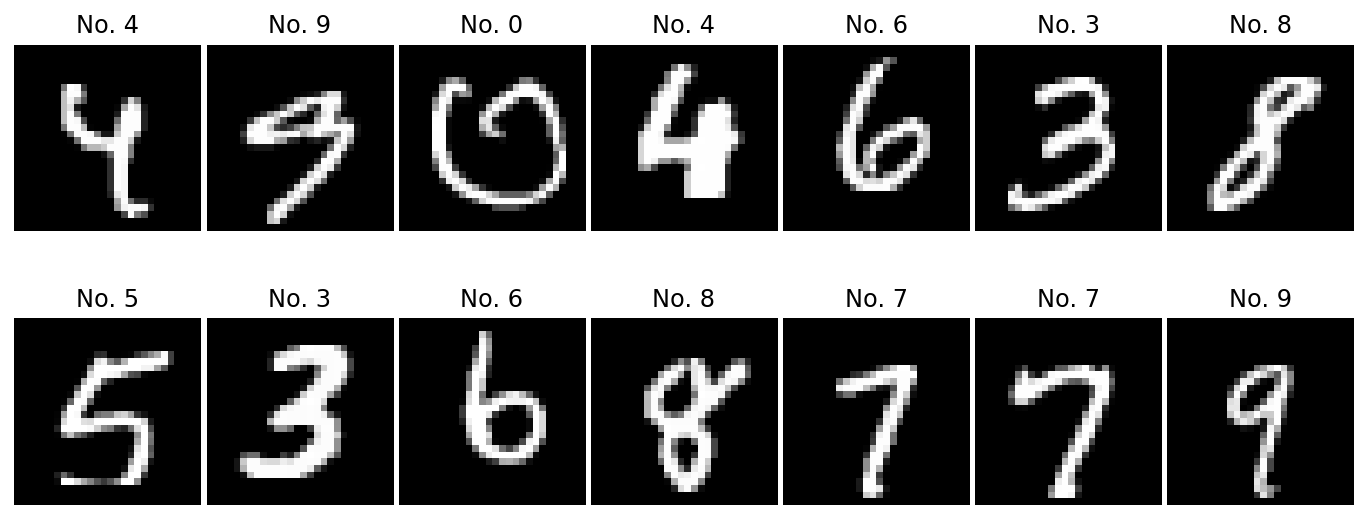

In [13]:
# display 14 random images from the training set
np.random.seed(123)

rand_14 = np.random.randint(0, x_train_orig.shape[0],14)
sample_digits = x_train_orig[rand_14]
sample_labels = y_train_orig[rand_14]
# code to view the images
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_digits[image_index], cmap='gray')
        ax[r,c].set_title('No. %d' % sample_labels[image_index])
plt.show()
plt.close()

### Random forest comparisons ###

In [14]:
# the data, split between train and test sets
(x_train_rf, y_train_rf), (x_test_rf, y_test_rf) = mnist.load_data()


# Transform data into flatten vectors

xtrain_rf = []
for x in x_train_rf:
    xtrain_rf.append(x.flatten())

clf = RandomForestClassifier(n_estimators=20, max_depth=4,random_state=0)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = cross_val_score(estimator = clf , X=xtrain_rf,y=y_train_rf, cv=kfold)

np.mean(results)

0.7774333333333333

### Convolutional model

In [16]:
batch_size = 128
num_classes = 10
epochs = 7

model = CNNModel(num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.01),
              metrics=['accuracy'])

t0 = time.time()
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
t1 = time.time()
print("Diff =", t1 - t0)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 28s 58ms/step - loss: 2.2857 - accuracy: 0.1535 - val_loss: 2.1848 - val_accuracy: 0.5408
Epoch 2/20
469/469 [==============================] - 27s 58ms/step - loss: 2.0347 - accuracy: 0.6120 - val_loss: 0.9986 - val_accuracy: 0.7829
Epoch 3/20
469/469 [==============================] - 28s 59ms/step - loss: 0.8000 - accuracy: 0.8038 - val_loss: 0.4549 - val_accuracy: 0.8755
Epoch 4/20
469/469 [==============================] - 27s 58ms/step - loss: 0.4447 - accuracy: 0.8783 - val_loss: 0.3541 - val_accuracy: 0.8965
Epoch 5/20
469/469 [==============================] - 27s 57ms/step - loss: 0.3613 - accuracy: 0.8969 - val_loss: 0.3010 - val_accuracy: 0.9112
Epoch 6/20
469/469 [==============================] - 27s 59ms/step - loss: 0.3150 - accuracy: 0.9094 - val_loss: 0.2644 - val_accuracy: 0.9229
Epoch 7/20
469/469 [==============================] - 27s 58ms/step - loss: 0.2789 - accuracy: 0.9198 - val_loss: 0.2369 - val_accuracy:

### References  

- A quite nice and not too technical reading is [this medium blog post](https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
